В этом задании нужно обучить нейронную сеть с нелинейной архитектурой и создать кастомную сигнатуру этой модели для загрузки в TensorFlow Serving.  

Для этого поработаем с базой резюме с HeadHunter и обучим нейронную сеть для решения задачи оценки зарплаты пользователя по указанным данным.  

Весь код по обработке данных уже готов и полностью в вашем распоряжении. Вам же необходимо выполнить следующие этапы:    

1. Запустите все ячейки ноутбука с загрузкой и предобработкой данных.

2. Создайте и обучите модель нейронной сети с тремя входами для обработки: 
 * числовых данных
 * текстовых данных "должность" 
 * текстовых данных "опыт работы"

3. Задайте кастомную сигнатуру модели и сохраните обученную нейронную сеть. Выведите сигнатуру сохраненной модели.

4. Запустите TensorFlow Serving в Colab.

5. Отправьте несколько примеров тестового набора данных на сервер для предсказания при помощи POST-запроса. 

6. Полученные результаты сравните с реальными значениями зарплат.

Импорт библиотек

In [ ]:
# Модуль для работы с операционной системой
import os

# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

# Библиотека tensorflow
import tensorflow as tf
import keras

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для создания модели нейронной сети
from tensorflow.keras.models import Model

# Слои для создания нейронной сети
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, concatenate

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Разделение данных на выборки
from sklearn.model_selection import train_test_split

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

Загрузка и подготовка данных

In [ ]:
# скачиваем базу
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head()

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
# Настройка номеров столбцов

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

### Преобразование числовых данных

In [ ]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0, 
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0, 
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0, 
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]

In [ ]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [ ]:
 # Получение one hot encoding представления значения класса
 
 def int_to_ohe(arg, class_list):
  
    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
# Разбор значений пола, возраста

base_update_year = 2019

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [ ]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [ ]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [ ]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [ ]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)
    city = split_array[0]  # Берем первое слово строки - это и есть город
    
    # Поиск города в словаре и присвоение класса
    city_cls = city_class[1].get(city.lower(), -1)
    
    # Если город не в city_class - значит его класс "прочие города"
    if city_cls < 0:   
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [ ]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)
    
    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.
    
    return result

In [ ]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0
    
    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

Функции подготовки выборок

In [ ]:
def extract_row_data(row):
  
    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe, 
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])
    
    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных    
x, y = construct_train_data(df.values)

In [ ]:
# Форма наборов параметров и зарплат
print(x.shape) 
print(y.shape)

# Пример обработанных данных
n = 0 
print(x[n])
print(y[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


### Преобразование текстовых данных

#### Подготовка текстовых данных "Должность"

In [ ]:
# Функция извлечения данных о профессии

def extract_prof_text(row_list):
    result = []
    
    # Для всех строк таблицы: собрать значения 
    # столбцов желаемой и прошлой должности
    # если есть информация о зарплате
    
    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_POS_SEEK]) + ' ' + str(row[COL_POS_PREV]))
    
    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов о профессии для выборки
prof_text = extract_prof_text(df.values) 

# Пример текста о профессии из резюме
print(df.values[120])
print(prof_text[120]) 

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
prof_tokenizer = Tokenizer(num_words=3000,                                       # Объем словаря
                           filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # Убираемые из текста ненужные символы
                           lower=True,                                           # Приведение слов к нижнему регистру
                           split=' ',                                            # Разделитель слов
                           oov_token='unknown',                                  # Токен для слов, которые не вошли в словарь 
                           char_level=False)                                     # Указание разделять по словам, а не по единичным символам

prof_tokenizer.fit_on_texts(prof_text) # Обучаем токенайзер

In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
prof_seq = prof_tokenizer.texts_to_sequences(prof_text)

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_prof = prof_tokenizer.sequences_to_matrix(prof_seq)

In [ ]:
# Проверка результата
print(x_prof.shape)

(62967, 3000)


#### Подготовка текстовых данных "Опыт работы"

In [ ]:
# Функция извлечения данных описания опыта работы

def extract_exp_text(row_list):
    result = []
    
    # Для всех строк таблицы: собрать значения опыта работы,
    # если есть информация о зарплате
    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_EXP]))
    
    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов об опыте работы для выборки
exp_text = extract_exp_text(df.values) 

# Пример текста об опыте работы из резюме
print(df.values[120])
print(exp_text[120]) 

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
exp_tokenizer = Tokenizer(num_words=3000,                                       # Объем словаря
                          filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # Убираемые из текста ненужные символы
                          lower=True,                                           # Приведение слов к нижнему регистру
                          split=' ',                                            # Разделитель слов
                          oov_token='unknown',                                  # Токен для слов, которые не вошли в словарь 
                          char_level=False)                                     # Указание разделять по словам, а не по единичным символам

exp_tokenizer.fit_on_texts(exp_text) # Обучаем токенайзер

In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
exp_seq = exp_tokenizer.texts_to_sequences(exp_text)

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_exp = exp_tokenizer.sequences_to_matrix(exp_seq)

In [ ]:
# Проверка результата
print(x_exp.shape)

(62967, 3000)


### Формирование выборок

In [ ]:
x_train, x_test, x_train_prof, x_test_prof, x_train_exp, x_test_exp, y_train, y_test = train_test_split(x,
                                                                                                        x_prof,
                                                                                                        x_exp,
                                                                                                        y,
                                                                                                        test_size=0.1,
                                                                                                        random_state=42)

Нормализация данных

In [ ]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных обучающей выборки
y_train_scaled = y_scaler.fit_transform(y_train)

# Нормализация выходных данных тестовой выборки
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
# Проверка нормализации
print(y_train_scaled.shape)
print(f'Оригинальное значение зарплаты:  {y_train[1, 0]}')
print(f'Нормированное значение зарплаты: {y_train_scaled[1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train.mean(), y_train.std())
print(y_train_scaled.mean(), y_train_scaled.std())

(56670, 1)
Оригинальное значение зарплаты:  70.0
Нормированное значение зарплаты: -0.11018971877657593
77.97819040056469 72.40412707415571
-1.7829394216531895e-16 1.0


In [ ]:
print(x_train.shape, x_train_prof.shape, x_train_exp.shape, y_train.shape)

(56670, 39) (56670, 3000) (56670, 3000) (56670, 1)


In [ ]:
print(type(x_train[0,0]),type(x_train_prof[0,0]),type(x_train_exp[0,0]))

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


In [ ]:
# Создаем простую модель сверточной нейронной сети
inputs1 = keras.Input(shape=x_train[0].shape)
inputs2 = keras.Input(shape=x_train_prof[0].shape)
inputs3 = keras.Input(shape=x_train_exp[0].shape)
x1=keras.layers.Dense(20, activation='tanh')(inputs1)
x2=keras.layers.Dense(20, activation='tanh')(inputs2)
x3=keras.layers.Dense(20, activation='tanh')(inputs3)
x1 = keras.layers.Concatenate()([x1,x2,x3])
x1 = keras.layers.Dropout(0.5)(x1)
x1=keras.layers.Dense(20, activation='tanh')(x1)
outputs=keras.layers.Dense(1, activation='linear')(x1)
model = keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=outputs)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mean_squared_error',metrics=['accuracy'])

# Обучаем модель
model.fit([x_train,x_train_prof,x_train_exp],y_train_scaled,validation_data=([x_test,x_test_prof,x_test_exp],y_test_scaled), epochs=30)

# Проверяем модель на тестовой выборке
print('\nПроверка модели:')
test_loss, test_acc = model.evaluate([x_test,x_test_prof,x_test_exp],y_test_scaled)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 20)           800         ['input_4[0][0]']                
                                                                                            

In [ ]:
# Создание кастомной сигнатуры с помощью класса tf.Module
class MyModule(tf.Module):
    def __init__(self, model):  # При инициализации экземпляра класса передаем модели нейронной сети
        self.model = model      # Присваиваем модель в переменную
    
    @tf.function(input_signature=([tf.TensorSpec(shape=(None,x_train.shape[-1]), dtype=tf.float32)], 
                                  [tf.TensorSpec(shape=(None,x_train_prof.shape[-1]), dtype=tf.float32)], 
                                  [tf.TensorSpec(shape=(None,x_train_exp.shape[-1]), dtype=tf.float32)])) # Вызываем декоратор, указывая формы тензоров, которые будут поступать на вход метода.
    def compare(self, input_1, input_2, input_3):
        output = self.model([input_1,input_2,input_3])              # Подаем первое изображение на вход нейронной сети и классифицируем его
        return {"result": output}                   # Возвращаем результат

In [ ]:
module = MyModule(model) # Вызываем класс MyModule

In [ ]:
signatures = {"compare": module.compare}

In [ ]:
MODEL_DIR = '/content/tmp'                             # Путь к директории для хранения моделей
version = 1                                            # Номер версии модели
export_path = os.path.join(MODEL_DIR, str(version))    # Путь к директории для хранения модели с заданной версией

In [ ]:
tf.saved_model.save(module,                # Передаем модель, которую нужно сохранить
                    export_path,           # Путь для сохранения
                    signatures=signatures) # Указываем сигнатуру модели

INFO:tensorflow:Assets written to: /content/tmp/1/assets


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['compare']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 39)
        name: compare_input_1:0
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3000)
        name: compare_input_2:0
    inputs['input_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3000)
        name: compare_input_3:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['result'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
       

In [ ]:
!zip -r '/content/model.zip' '/content/tmp'

  adding: content/tmp/ (stored 0%)
  adding: content/tmp/1/ (stored 0%)
  adding: content/tmp/1/assets/ (stored 0%)
  adding: content/tmp/1/saved_model.pb (deflated 89%)
  adding: content/tmp/1/variables/ (stored 0%)
  adding: content/tmp/1/variables/variables.index (deflated 68%)
  adding: content/tmp/1/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
import json # Модуль для кодирования и декодирования данных в формате json
data = json.dumps({"signature_name": "compare", """instances""":[{"""input_1""":x_test[10].tolist(),"""input_2""":x_test_prof[10].tolist(),"""input_3""":x_test_exp[10].tolist()}]})

In [ ]:
data

'{"signature_name": "compare", "instances": [{"input_1": [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], "input_2": [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
json_file = open('predict.json', 'w') # Создаем файл в формате JSON и открываем его для записи
json_file.write(data)                 # Записываем данные
json_file.close()                     # Закрываем файл

In [ ]:
from google.colab import files
files.download("predict.json")
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
arr=model.predict([x_test[10].reshape(1,-1),x_test_prof[10].reshape(1,-1),x_test_exp[10].reshape(1,-1)])
arr

array([[-0.19270754]], dtype=float32)

In [ ]:
y_scaler.inverse_transform(arr)

array([[64.02537]], dtype=float32)

In [ ]:
json_file = open('response.json', 'r') # Открываем JSON-файл для чтения
response = json_file.read()            # Читаем данные
json_file.close()                      # Закрываем файл

In [ ]:
response

'{\n    "predictions": [[-0.192707539]\n    ]\n}'

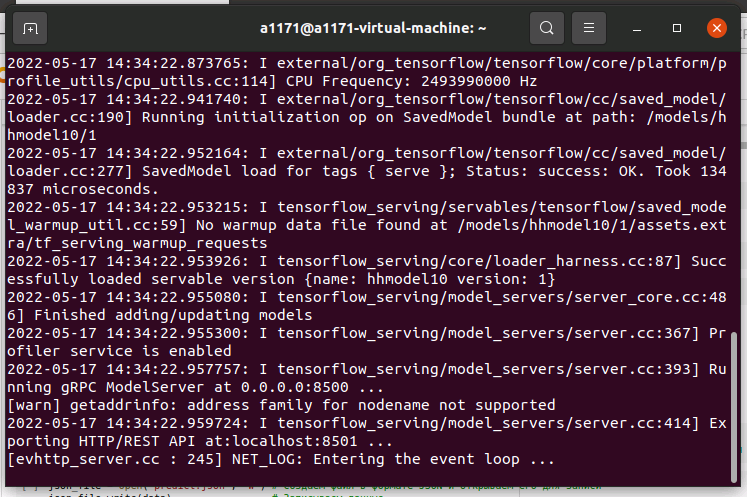

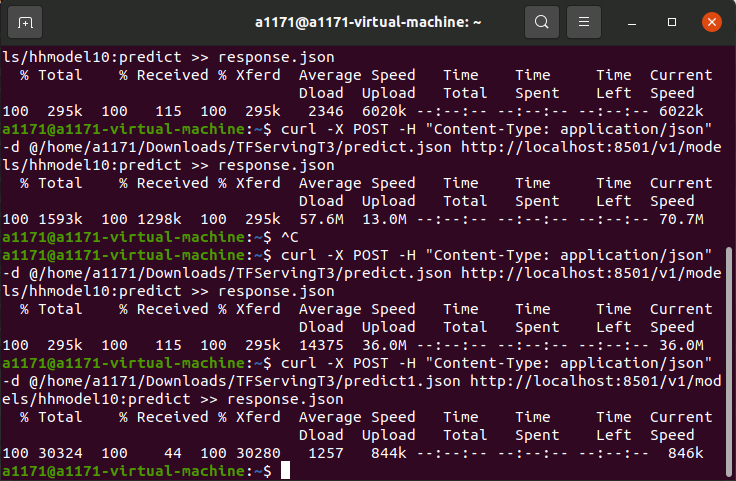

Дальше тесты и комментарии

Строки передать не получилось. При попытке создать сигнатуру tf.TensorSpec(shape=(), dtype=tf.string)  и внутри вызывать токенайзеры для обработки текста выдает ошибку что не может вызвать функцию lower() у тенсорвлововской строки. Видимо токенайзер пытался. Как передавать строки?

несколько примеров тоже не принимает. Хотя в сигнатуре написана форма (-1,39) при попытке передать тенсор (10,39) возвращает ошибку что приходит форма (1,10,39)  у меня лишних скобок точно небыло.  А принимает форму (39), хотя должен принимать (1,39) . т.е. сервер сам внутри добавляет к тензорам первые оси с размерностью 1. Почему он так делает и как передать несколько примеров?

nohup tensorflow_model_server --rest_api_port=8501 --model_name= hhmodel10 --model_base_path="${MODEL_DIR}" > server.log 2>&1

export MODEL_DIR=/home/a1171/Downloads/TFServingT3/tmp/

echo "${MODEL_DIR}"

sudo chmod 666 /var/run/docker.sock

docker ps

docker stop

docker run -p 8501:8501 --mount type=bind,source=/home/a1171/Downloads/TFServingT3/tmp,target=/models/hhmodel10 -e MODEL_NAME=hhmodel10 -t tensorflow/serving

curl -X POST -H "Content-Type: application/json" -d @/home/a1171/Downloads/TFServingT3/predict.json http://localhost:8501/v1/models/hhmodel10:predict >> response.json

sudo lsof -i -P -n | grep 8501
kill -9 3518

In [ ]:
# Создание кастомной сигнатуры с помощью класса tf.Module
class MyModule(tf.Module):
    def __init__(self, model,prof_tokenizer,exp_tokenizer):  # При инициализации экземпляра класса передаем модели нейронной сети
        self.model = model      # Присваиваем модель в переменную
        self.prof_tokenizer = prof_tokenizer
        self.exp_tokenizer = exp_tokenizer
    
    @tf.function(input_signature=([tf.TensorSpec(shape=(None,x_train.shape[-1]), dtype=tf.float32)], 
                                  [tf.TensorSpec(shape=(), dtype=tf.string)], 
                                  [tf.TensorSpec(shape=(), dtype=tf.string)])) # Вызываем декоратор, указывая формы тензоров, которые будут поступать на вход метода.
    def compare(self, input_1, input_2, input_3):
        prof_seq = self.prof_tokenizer.texts_to_sequences(str(input_2.numpy()))
        x_prof = self.prof_tokenizer.sequences_to_matrix(prof_seq)
        exp_seq = self.exp_tokenizer.texts_to_sequences(str(input_3.numpy()))
        x_exp = self.exp_tokenizer.sequences_to_matrix(exp_seq)

        output = self.model(input_1,x_prof,x_exp)              # Подаем первое изображение на вход нейронной сети и классифицируем его
        return {"result": output}                   # Возвращаем результат